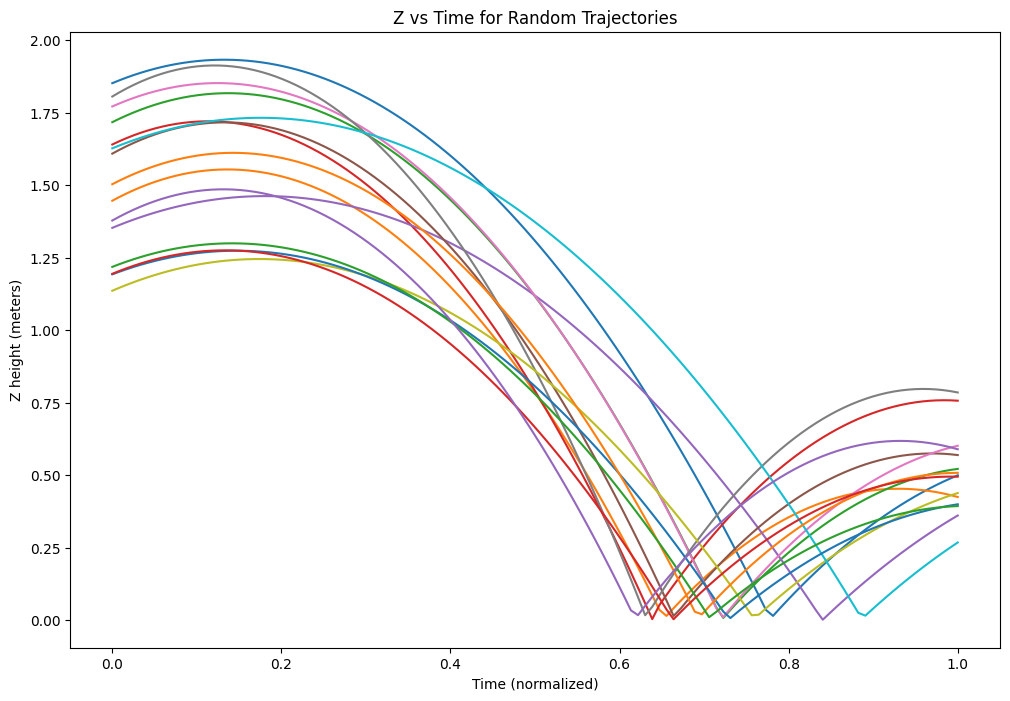

In [357]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# load one chunk
X = np.load(f"synthetic_data/X_train_chunk{1}.npy")
y = np.load(f"synthetic_data/y_train_chunk{1}.npy")

# pick a few random trajectories
indices = np.random.choice(len(y), size=15, replace=False)

time = np.linspace(0, 1, y.shape[1])  # normalized time (60 frames)

plt.figure(figsize=(12,8))
for idx in indices:
    plt.plot(time, y[idx])

plt.xlabel("Time (normalized)")
plt.ylabel("Z height (meters)")
plt.title("Z vs Time for Random Trajectories")
plt.show()

In [366]:
from mpl_toolkits.mplot3d import Axes3D

# load one chunk
X = np.load(f"synthetic_data/X_train_chunk{1}.npy")  # (N, 60, 2)
y = np.load(f"synthetic_data/y_train_chunk{1}.npy")  # (N, 60)

# pick random trajectories
indices = np.random.choice(len(y), size=2, replace=False)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

for idx in indices:
    u = X[idx, :, 0]  # pixel x
    v = X[idx, :, 1]  # pixel y
    z = y[idx]        # height in meters

    ax.plot(u, v, z)

ax.set_xlabel("Pixel X")
ax.set_ylabel("Pixel Y")
ax.set_zlabel("Z (meters)")
ax.set_title("3D Synthetic Tennis Trajectories")

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'synthetic_data/X_train_chunk1.npy'

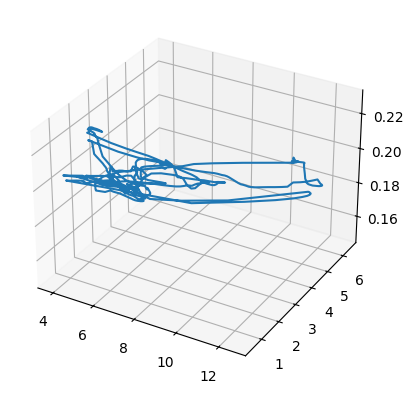

In [364]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pts = np.loadtxt("trajectory.csv", delimiter=",")
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(pts[:,0], pts[:,1], pts[:,2])
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from model import Reconstructor, PositionalEncoding

DATA_ROOT = "synthetic_data"
MODEL_PATH = "reconstructor.keras"
BATCH_SIZE = 256
N_PLOT_SAMPLES = 5

model = tf.keras.models.load_model(MODEL_PATH, compile=False, custom_objects={
    "Reconstructor": Reconstructor,
    "PositionalEncoding": PositionalEncoding,
})
_ = model(tf.random.uniform((1, 120, 2)))

X_files = sorted(glob.glob(os.path.join(DATA_ROOT, "X_train_chunk*.npy")))
y_files = sorted(glob.glob(os.path.join(DATA_ROOT, "y_train_chunk*.npy")))

total_mse = 0.0
total_mae = 0.0
total_samples = 0

all_preds = []
all_gt = []

for X_path, y_path in zip(X_files, y_files):
    X = np.load(X_path).astype(np.float32)
    y = np.load(y_path).astype(np.float32)

    dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(BATCH_SIZE)

    for x_batch, y_batch in dataset:
        preds = model(x_batch, training=False)
        preds = tf.cast(preds, tf.float32)

        if len(preds.shape) == 3:
            preds = tf.squeeze(preds, axis=-1)

        mse = tf.reduce_mean(tf.square(y_batch - preds))
        mae = tf.reduce_mean(tf.abs(y_batch - preds))

        bs = x_batch.shape[0]

        total_mse += mse.numpy() * bs
        total_mae += mae.numpy() * bs
        total_samples += bs

        all_preds.append(preds.numpy())
        all_gt.append(y_batch.numpy())

mean_mse = total_mse / total_samples
mean_rmse = np.sqrt(mean_mse)
mean_mae = total_mae / total_samples

print("MSE:", mean_mse)
print("RMSE:", mean_rmse)
print("MAE:", mean_mae)

preds_all = np.concatenate(all_preds, axis=0)
gt_all = np.concatenate(all_gt, axis=0)

traj_rmse = np.sqrt(np.mean((preds_all - gt_all) ** 2, axis=1))

print("Per-trajectory RMSE mean:", traj_rmse.mean())
print("Per-trajectory RMSE median:", np.median(traj_rmse))
print("Per-trajectory RMSE max:", traj_rmse.max())

idx = np.random.choice(len(preds_all), N_PLOT_SAMPLES, replace=False)

plt.figure(figsize=(12, 8))
for i, j in enumerate(idx):
    plt.subplot(N_PLOT_SAMPLES, 1, i + 1)
    plt.plot(gt_all[j])
    plt.plot(preds_all[j])
plt.tight_layout()
plt.show()


MSE: 0.0
RMSE: 0.0
MAE: 0.0


ValueError: need at least one array to concatenate